In [1]:
import os
nthreads = 1
os.environ["OMP_NUM_THREADS"] = str(nthreads)
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads)
os.environ["MKL_NUM_THREADS"] = str(nthreads)

In [2]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import inferagni as ia

/home/harrison/miniforge3/envs/proteus/lib/python3.12/site-packages/astropy/config/paths.py:55: AstropyUserWarning: XDG_CONFIG_HOME is set to '/home/harrison/.var/app/com.visualstudio.code/config', but the default location, /home/harrison/.astropy/config, already exists, and takes precedence. This environment variable will be ignored.
  return set_temp_config._get_dir_path(rootname)


In [3]:
# %config InlineBackend.figure_format = 'retina'

In [4]:
datadir = "../src/inferagni/data/"

gr = ia.grid.Grid(datadir)

Loading data from disk...
    Source: /home/harrison/Projects/InferAGNI/src/inferagni/data
Loading grid of scalar quantities
    Grid size: 264600 points
    Input vars:
      Teff              : range [2500.0, 5750.0]
      instellation      : range [1.0, 1000.0]
      logZ              : range [-2.0, 1.0]
      logCO             : range [-3.0, 0.0]
      mass_tot          : range [1.0, 10.0]
      frac_core         : range [0.20000000298023224, 0.699999988079071]
      frac_atm          : range [0.0010000000474974513, 0.25]
    Output vars: 
      succ, flux_loss, r_bound, p_surf,
      t_surf, r_surf, μ_surf, g_surf, t_phot,
      r_phot, μ_phot, g_phot, vmr_H2,
      vmr_H2O, vmr_CO2, vmr_CO, vmr_O2,
      vmr_OH, vmr_NH3, vmr_NO2, vmr_N2,
      vmr_SO2, vmr_H2S, vmr_H2SO4, Kzz_max,
      conv_ptop, conv_pbot, H_phot
Loading emission spectra
    done
Loading atmosphere profiles
    done
--------------------------------------------------



In [5]:
# Observables (already scaled)

# L 98-59 d
obs = {
    "_name":        "L 98-59 d",
    "r_phot":       [1.521, (0.119,0.098)],
    "mass_tot":     [2.14,  (0.25,0.29)],
    "μ_phot":       [9.18,  (2.51,2.41)],
    # "instellation": [5.0,    0.5],
    "Teff":         [3415.0, 60.0]
}

# GJ 9827 d
# obs = ia.planets.get_obs("GJ 9827 d")
# obs["μ_phot"] = [9.84,4.5]

# Others
# obs = ia.planets.get_obs("K2-18 b")
# obs = ia.planets.get_obs("TRAPPIST-1 c")

In [6]:
# Do retrieval
keys, samples = ia.retrieve.run(gr, obs,
                                n_walkers=22, n_procs=10, n_steps=3000,
                                extra_keys=["vmr_H2O"])

Prepare interpolators
Creating interpolator on frac_core
    Organising data
    Interpolator ready
Creating interpolator on μ_phot
    Organising data
    Interpolator ready
Creating interpolator on logCO
    Organising data
    Interpolator ready
Creating interpolator on instellation
    Organising data
    Interpolator ready
Creating interpolator on vmr_H2O
    Organising data
    Interpolator ready
Creating interpolator on logZ
    Organising data
    Interpolator ready
Creating interpolator on frac_atm
    Organising data
    Interpolator ready
Creating interpolator on mass_tot
    Organising data
    Interpolator ready
Creating interpolator on Teff
    Organising data
    Interpolator ready
Creating interpolator on r_phot
    Organising data
    Interpolator ready
 
Copy grid object into module global scope
Spawning 22 walkers using 10 processes
Observables:
    r_phot            :      1.521 (+ 0.119      - 0.098     )
    mass_tot          :       2.14 (+ 0.25       - 0.29     

100%|██████████| 3200/3200 [00:39<00:00, 81.84it/s]


    done
 
Discarded 200 burn-in samples and thinned by 10
Samples: (6600, 7), length 46200

    Quantity    :    Median         (Uncertainty)             Autocorrelation
Teff            :    3414.86  (+ 60.1468     - 58.737    )    83.8991
instellation    :    42.0802  (+ 282.167     - 38.295    )    118.9766
logZ            :   0.485971  (+ 0.155607    - 0.228404  )    140.9508
logCO           :   -1.56424  (+ 1.05552     - 0.945682  )    137.8755
mass_tot        :    2.14829  (+ 0.25531     - 0.294989  )    104.7954
frac_core       :   0.419951  (+ 0.183916    - 0.148103  )    153.7606
frac_atm        : 0.00717634  (+ 0.0218267   - 0.00525807)    137.0175

Postprocessing grid with extra keys: ['vmr_H2O', 'μ_phot', 'r_phot']
    done


Plot retrieval chain with 6600 samples
    Showing plot GUI


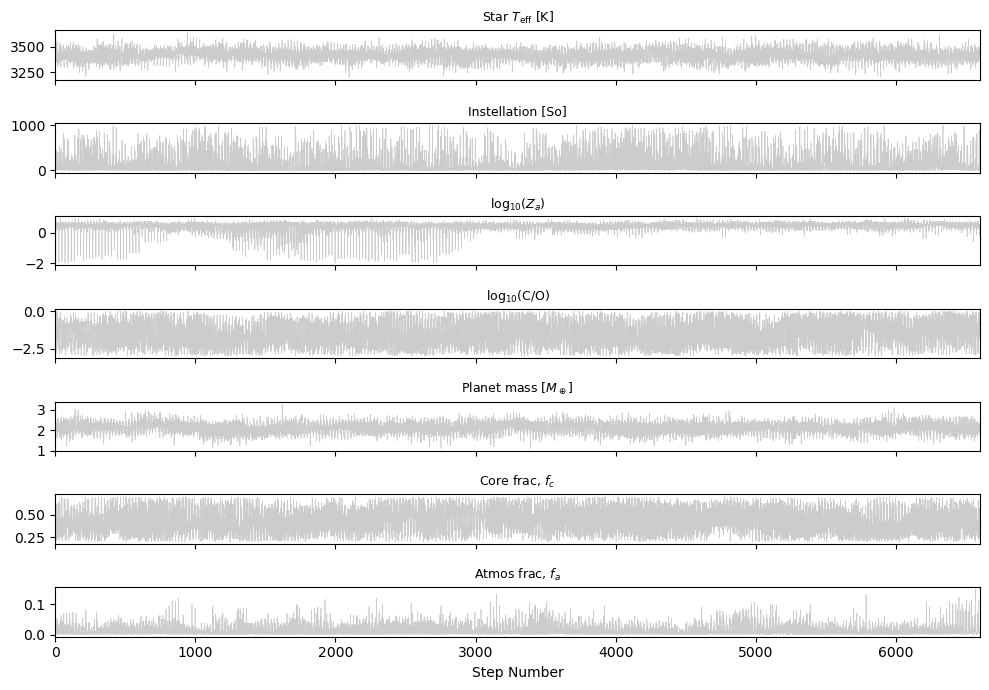

In [7]:
fig = ia.retrieve.plot_chain(samples,show=True)

Plot retrieval corner with 6600 samples


    Showing plot GUI


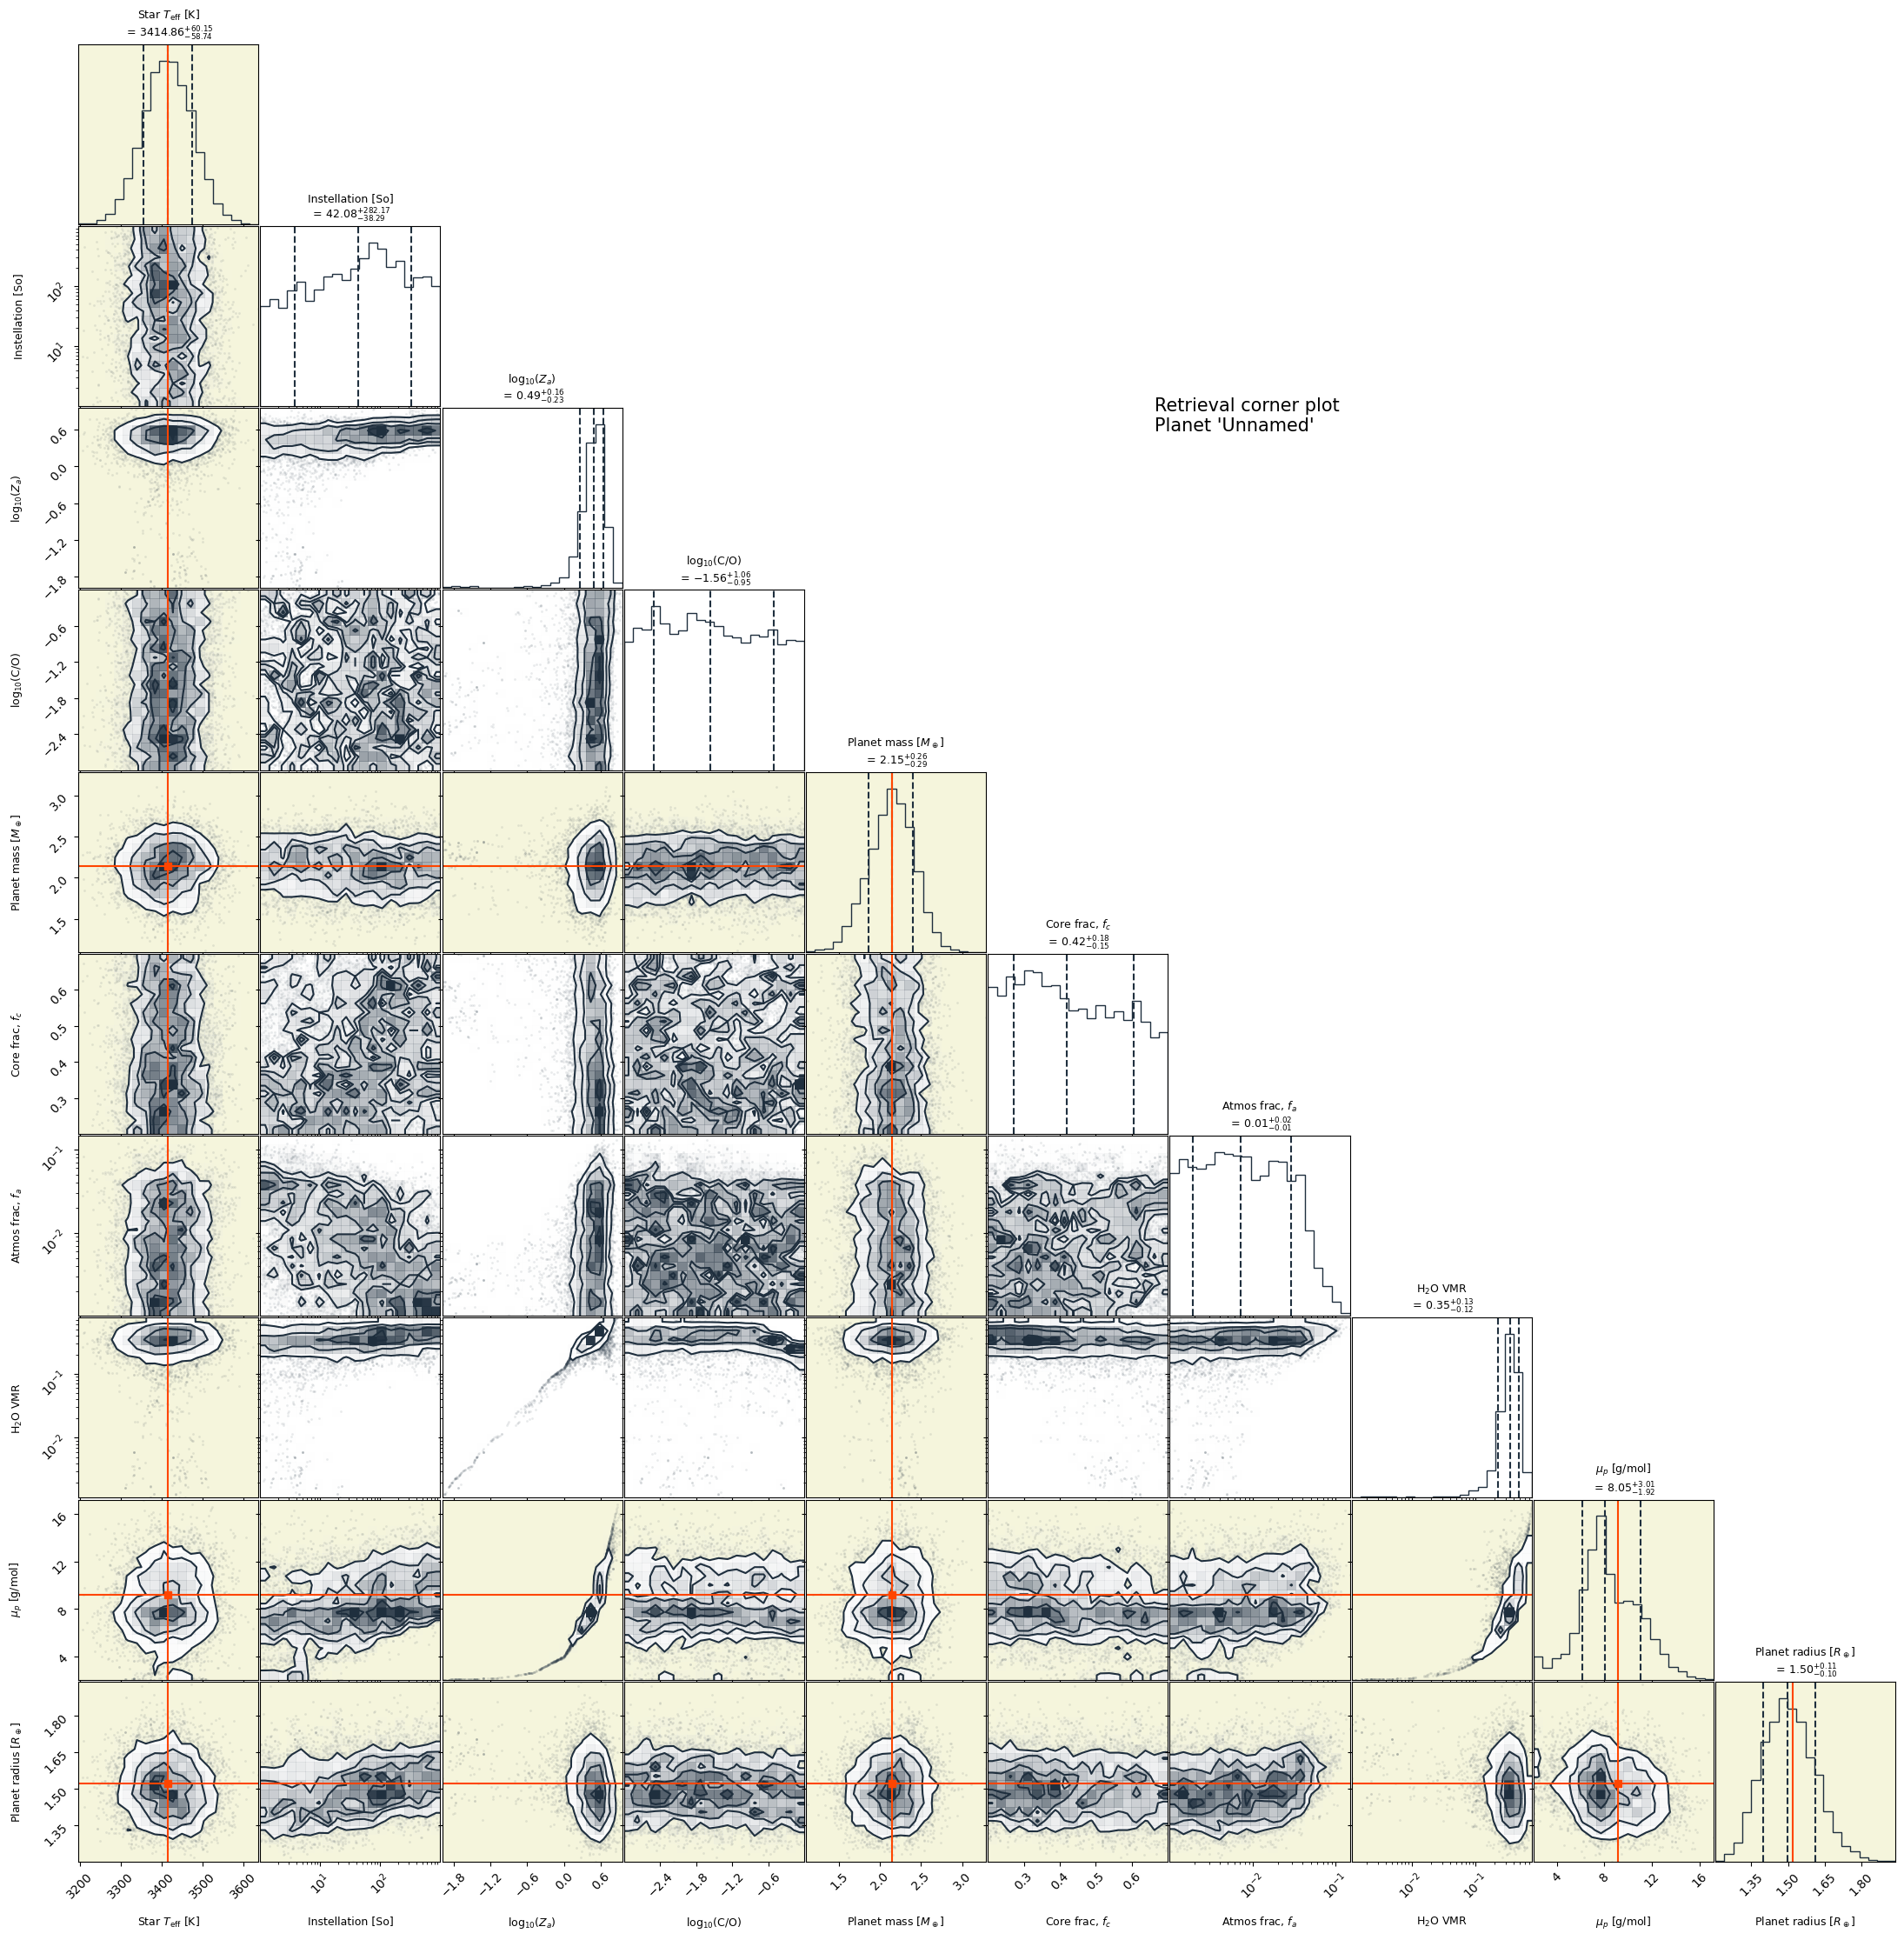

In [8]:
fig = ia.retrieve.plot_corner(keys, samples,show=True)

Sampled 1650 profiles


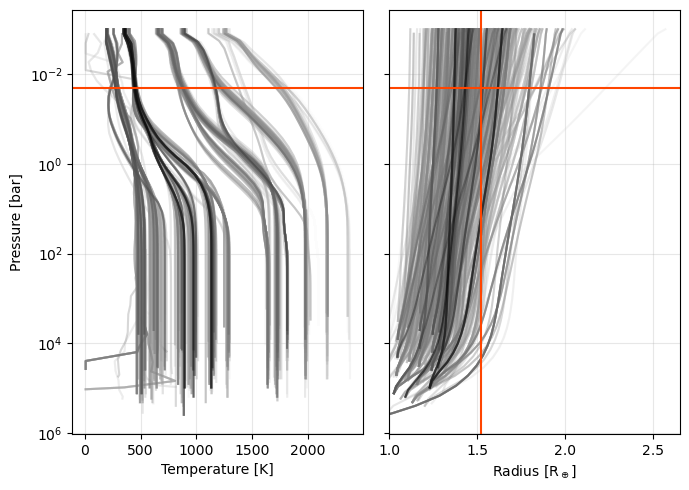

In [9]:
# Draw TP profiles from a random posterior sample set and approximate median T(p)

# assemble grid input array in the same order as `gr.input_keys`
X = np.vstack([gr.data.loc[:,k] for k in gr.input_keys]).T

# number of random draws to visualise
rng = np.random.default_rng(42)
max_chain = len(samples)
min_chain = int(max_chain*0.75)
draw_idx = rng.choice(range(min_chain,max_chain,1), size=max_chain-min_chain, replace=True)

profs = []
dists = []
for i in draw_idx:
    # get sample from chain
    params = samples[i,:len(gr.input_keys)]

    # get euclidean distances in parameter-space
    dist_params = np.linalg.norm(X - params, axis=1)

    # get index of closest gridpoint
    idx = int(np.argmin(dist_params))
    t = gr.profs['t'][idx,:].astype(float)
    p = gr.profs['p'][idx,:].astype(float) / ia.util.bar
    r = gr.profs['r'][idx,:].astype(float) / ia.util.R_earth

    dists.append(dist_params[idx])
    profs.append(dict(idx=idx, t=t, p=p, r=r))

print(f"Sampled {len(profs)} profiles")

# stack temperatures and compute median profile
T_stack = np.vstack([pr['t'] for pr in profs])
T_median = np.median(T_stack, axis=0)

# Colormap
sm = mpl.cm.ScalarMappable(cmap='gray',
                           norm=mpl.colors.LogNorm(vmin=np.amin(dists),vmax=np.amax(dists)))

# Plot ensemble and median T(p)
fig, axs = plt.subplots(1,2,figsize=(7,5),sharey=True)
axl,axr = axs
mask = np.argsort(dists)[::-1]
for i in mask:
    pr = profs[i]
    col = sm.to_rgba(dists[i])
    al = 0.5 * (np.amax(dists) - dists[i]) / (np.amax(dists)-np.amin(dists))
    axl.plot(pr['t'], pr['p'], alpha=al, color=col)
    axr.plot(pr['r'], pr['p'], alpha=al, color=col)

for ax in axs:
    ax.grid(True, which='both', alpha=0.3, zorder=-2)
    ax.axhline(20*1e-3, color='orangered')
axr.axvline(obs["r_phot"][0], color='orangered')


axl.set_yscale('log')
axl.invert_yaxis()
axl.set_ylabel('Pressure [bar]')

axl.set_xlabel(r'Temperature [K]')
axr.set_xlabel(r'Radius [R$_\oplus$]')
axr.set_xlim(left=1)


# ax.legend()
fig.tight_layout()
plt.show()